# VCI Bayes Explore

## 1. Environment Setup

Import dependencies, configure plotting defaults, and align pyAgrum's visual output.

In [1]:
# Core Python utilities
import base64
import io
import os
import random
from itertools import product
from pathlib import Path

# Numerical and data processing
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Visualisation helpers
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import display
from ipywidgets import interact, fixed

# Bayesian network tooling (pyAgrum ecosystem)
import pyagrum as gum
import pyagrum.lib.explain as explain
import pyagrum.lib.explain as expl
import pyagrum.lib.notebook as gnb
import pyagrum.lib.utils as gutils
import pyagrum.lib.bn2graph as gumb2g
import pyagrum.lib.bn_vs_bn as bnvsbn
import pyagrum.lib.bn_vs_bn as gcm
from pyagrum import BNLearner
from pyagrum.lib.bn2roc import showROC
from pyagrum.lib.discreteTypeProcessor import DiscreteTypeProcessor
import pyagrum.skbn as skbn
from pyagrum.skbn import BNClassifier

# Scikit-learn helpers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings

# Matplotlib defaults for manuscript-ready figures
warnings.filterwarnings('ignore', category=UserWarning)

mpl.rcParams['font.family'] = 'Helvetica Neue'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'regular'


In [98]:
# Utility: format dictionaries for side-by-side HTML display in the notebook
def dict2html(di1, di2=None):
  res = "<br/>".join([f"<b>{k:15}</b>:{v}" for k, v in di1.items()])
  if di2 is not None:
    res += "<br/><br/>"
    res += "<br/>".join([f"<b>{k:15}</b>:{v}" for k, v in di2.items()])
  return res


In [99]:
# Ensure pyAgrum renders graphs with consistent layouts across reruns
gum.config["notebook", "graph_layout"] = "dot"
gum.config["notebook", "graph_rankdir"] = "TB"


## 2. Data Loading and Preparation

Set `PROJECT_ROOT` so that `PROJECT_ROOT / data` holds the parquet exports required for the analysis, or run `src/preprocess_data.py` after configuring `config/data_paths.yml` to recreate them.

This notebook expects three inputs:
- `df.parquet`: raw cohort data without imputation (used for comparison plots).
- `df_imp.parquet`: fully imputed dataset feeding the Bayesian network learner.
- `bn_vars.parquet`: metadata table with at least `LAYER` and `VARIABLE NAME` columns describing the expert-assigned layer of each variable.

Update the configuration cell below if your repository layout differs.

In [100]:

import os
from pathlib import Path

PROJECT_ROOT = Path.cwd()


def _get_path_override(key: str, project_root: Path) -> Path | None:
    """Return path override from env var or .env without hard-coding paths."""
    env_value = os.environ.get(key)
    if env_value:
        return Path(env_value).expanduser()

    env_path = project_root / '.env'
    if not env_path.exists():
        return None

    for raw_line in env_path.read_text().splitlines():
        line = raw_line.strip()
        if not line or line.startswith('#') or '=' not in line:
            continue
        name, value = line.split('=', 1)
        if name.strip() == key:
            cleaned = value.strip()
            if cleaned[:1] in {'"', "'"} and cleaned[-1:] == cleaned[:1]:
                cleaned = cleaned[1:-1]
            if cleaned:
                return Path(cleaned).expanduser()
    return None


candidate_dirs = []

override_path = _get_path_override('BAYESIAN_DATA_DIR', PROJECT_ROOT)
if override_path:
    if not override_path.exists():
        raise FileNotFoundError(
            f"BAYESIAN_DATA_DIR={str(override_path)!r} does not exist. "
            "Update the override value or remove it."
        )
    candidate_dirs.append(override_path)

candidate_dirs += [
    PROJECT_ROOT / 'src' / 'out',
    PROJECT_ROOT / 'out',
    PROJECT_ROOT / 'data',
]

for candidate in candidate_dirs:
    if candidate.exists():
        DATA_DIR = candidate
        break
else:
    DATA_DIR = PROJECT_ROOT / 'data'


FileNotFoundError: [Errno 2] No such file or directory

In [5]:
# Load harmonised datasets used throughout the analysis
df = pd.read_parquet(DATA_DIR / 'df.parquet', engine='pyarrow')
df_imp = pd.read_parquet(DATA_DIR / 'df_imp.parquet', engine='pyarrow')
bn_vars = pd.read_parquet(DATA_DIR / 'bn_vars.parquet', engine='pyarrow')


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/GROUPS/HER/Onderzoek/Neurologie/VCI onderzoek/Malin Overmars/01_HARTBREIN/04_BAYESIAN_EXPLORE/src/data/df.parquet'

In [6]:
# Harmonise categorical entries before discretisation
for frame in (df, df_imp):
    # Replace blank or missing stroke history entries with explicit 'No'
    if 'STROKE HISTORY' in frame.columns:
        frame['STROKE HISTORY'] = frame['STROKE HISTORY'].replace({'': 'No', ' ': 'No'}).fillna('No')
    # Legacy CVA column cleaning (if present)
    if 'CVA' in frame.columns:
        frame['CVA'] = frame['CVA'].replace({'': 'Nee', ' ': 'Nee'}).fillna('Nee')


/var/folders/k7/m876w0ts2n77lwt3x1dc25zc0000gp/T/ipykernel_58747/4040133624.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  frame['STROKE HISTORY'] = frame['STROKE HISTORY'].replace({'': 'No', ' ': 'No'}).fillna('No')


### 2.2 Metadata sanity check
The `bn_vars` table should map every variable used in the network to its corresponding layer.
If you add new variables, ensure the parquet file lists them with the desired `LAYER` label.

Example `bn_vars.parquet` structure (first columns):

| LAYER | VARIABLE NAME | DESCRIPTION |
| --- | --- | --- |
| L0 – Unmodifiable demographics | AGE | Baseline age in years |
| L0 – Unmodifiable demographics | SEX | Biological sex at baseline |
| L2 – Cardiovascular risk factors | VASCULAR RISK SCORE | SCORE2 cardiovascular risk estimate |
| L4 – Potential disease process markers | PTAU181 | Plasma pTau181 concentration category |
| L6 – Current and previous cardiovascular diagnoses / Vascular interventions | PATIENT GROUP | Diagnostic cohort label |
| L8 – Outcomes | OUTCOME_MACE | Binary indicator of follow-up MACE |

Add extra columns (e.g. `DISPLAY NAME`, `NOTES`) as needed—the loader only requires `LAYER` and `VARIABLE NAME`.

In [7]:
# Ensure DROPOUT REASON is mapped to the dropout layer
if 'bn_vars' in globals():
    if 'DROPOUT REASON' not in bn_vars['VARIABLE NAME'].values:
        bn_vars = pd.concat([bn_vars, pd.DataFrame([{'LAYER': 'L9 – Dropout', 'VARIABLE NAME': 'DROPOUT REASON'}])], ignore_index=True)
    else:
        bn_vars.loc[bn_vars['VARIABLE NAME'] == 'DROPOUT REASON', 'LAYER'] = 'L9 – Dropout'


In [8]:
# Preview the first few rows once bn_vars.parquet is loaded
bn_vars.sort_values(['LAYER', 'VARIABLE NAME'])

,LAYER,VARIABLE NAME
12,L0 – Unmodifiable demographics,AGE
13,L0 – Unmodifiable demographics,SEX
21,L2 – Cardiovascular risk factors,VASCULAR RISK SCORE
18,L4 – Potential disease process markers,AB40
19,L4 – Potential disease process markers,AB42
4,L4 – Potential disease process markers,BIOMARKER SCORE 1
5,L4 – Potential disease process markers,BIOMARKER SCORE 2
9,L4 – Potential disease process markers,CEREBRAL BLOOD FLOW
16,L4 – Potential disease process markers,GFAP
15,L4 – Potential disease process markers,NFL


In [9]:
# Validate the metadata layout before building the network
expected_columns = {'LAYER', 'VARIABLE NAME'}
missing_cols = expected_columns - set(bn_vars.columns)
if missing_cols:
    raise ValueError(f"bn_vars is missing required columns: {missing_cols}")

print('Layers discovered in bn_vars:', sorted(bn_vars['LAYER'].unique()))
display(bn_vars.head())


Layers discovered in bn_vars: ['L0 – Unmodifiable demographics', 'L2 – Cardiovascular risk factors', 'L4 – Potential disease process markers', 'L5 - Imaging markers of neurovascular damage', 'L6 – Current and previous cardiovascular diagnoses / Vascular interventions', 'L6 – Current and previous cardiovascular diagnoses / Vascular interventions ', 'L7 - Functional status', 'L8 – Outcomes', 'L9 – Dropout']


,LAYER,VARIABLE NAME
0,L7 - Functional status,MINI MENTAL STATE EXAMINATION
1,L7 - Functional status,STARKSTEIN SCORE
2,L7 - Functional status,BASELINE CDR
3,L6 – Current and previous cardiovascular diagn...,STROKE HISTORY
4,L4 – Potential disease process markers,BIOMARKER SCORE 1


## 3. Variable Discretisation

Configure the binning strategy feeding each learner and inspect the resulting template.

In [10]:
# Configure discretisation defaults for mixed-type clinical variables
type_processor = DiscreteTypeProcessor(
  defaultDiscretizationMethod="quantile", defaultNumberOfBins=4, discretizationThreshold=10
)

In [11]:
# Inspect the discretised template to document the bins used by the learner
# creating a template explaining the variables proposed by the type_processor. This variables will be used by the learner
template = type_processor.discretizedTemplate(df_imp)
for i, n in template:
  print(f"{n:7} : {template.variable(i)}")

AGE     : AGE:Discretized(<(48.4928;61.5777[,[61.5777;68.0452[,[68.0452;73.6283[,[73.6283;92.4983)>)
SEX     : SEX:NumericalDiscrete({0|1})
PTAU181 : PTAU181:Discretized(<(-0.941953;1.2385[,[1.2385;1.57184[,[1.57184;2.20932[,[2.20932;11.0239)>)
NFL     : NFL:Discretized(<(-44.9761;13.2366[,[13.2366;18.2215[,[18.2215;26.5988[,[26.5988;309.426)>)
GFAP    : GFAP:Discretized(<(-1.89626;67.0368[,[67.0368;94.6837[,[94.6837;134.737[,[134.737;676.236)>)
AB40    : AB40:Discretized(<(8.19715;87.4806[,[87.4806;100.048[,[100.048;112.567[,[112.567;263.656)>)
AB42    : AB42:Discretized(<(0.510692;5.60809[,[5.60809;6.53351[,[6.53351;7.61622[,[7.61622;17.5025)>)
MINI MENTAL STATE EXAMINATION : MINI MENTAL STATE EXAMINATION:Discretized(<(15;27[,[27;29[,[29;30)>)
STARKSTEIN SCORE : STARKSTEIN SCORE:Discretized(<(0;7[,[7;9[,[9;12[,[12;32)>)
BASELINE CDR : BASELINE CDR:NumericalDiscrete({0|0.5|1})
STROKE HISTORY : STROKE HISTORY:Labelized({0|1|2|3|No})
SMALL VESSEL DISEASE SCORE : SMALL VESSEL DISEASE SCO

In [12]:
# Inspect the discretised template to document the bins used by the learner
template = type_processor.discretizedTemplate(df_imp)

def format_label(label):
    parts = label.strip('([)').split(';')
    lower = float(parts[0])
    upper = float(parts[1].replace('[', '').replace(')', ''))

    lower_rounded = round(lower, 1)
    upper_rounded = round(upper, 1)

    return f"({lower_rounded};{upper_rounded}["

for i, n in template:
    var = template.variable(i)
    labels = var.labels()

    # Check if the labels look like intervals
    if all((";" in label and "[" in label) for label in labels):
        formatted_labels = [format_label(label) for label in labels]
        print(f"{n:7} : {formatted_labels}")
    else:
        print(f"{n:7} : {labels}")


AGE     : ['(48.5;61.6[', '(61.6;68.0[', '(68.0;73.6[', '(73.6;92.5[']
SEX     : ('0', '1')
PTAU181 : ['(-0.9;1.2[', '(1.2;1.6[', '(1.6;2.2[', '(2.2;11.0[']
NFL     : ['(-45.0;13.2[', '(13.2;18.2[', '(18.2;26.6[', '(26.6;309.4[']
GFAP    : ['(-1.9;67.0[', '(67.0;94.7[', '(94.7;134.7[', '(134.7;676.2[']
AB40    : ['(8.2;87.5[', '(87.5;100.0[', '(100.0;112.6[', '(112.6;263.7[']
AB42    : ['(0.5;5.6[', '(5.6;6.5[', '(6.5;7.6[', '(7.6;17.5[']
MINI MENTAL STATE EXAMINATION : ['(15.0;27.0[', '(27.0;29.0[', '(29.0;30.0[']
STARKSTEIN SCORE : ['(0.0;7.0[', '(7.0;9.0[', '(9.0;12.0[', '(12.0;32.0[']
BASELINE CDR : ('0', '0.5', '1')
STROKE HISTORY : ('0', '1', '2', '3', 'No')
SMALL VESSEL DISEASE SCORE : ['(0.0;1.0[', '(1.0;2.0[', '(2.0;4.0[']
BIOMARKER SCORE 1 : ['(-1.7;-0.3[', '(-0.3;0.0[', '(0.0;0.4[', '(0.4;3.9[']
BIOMARKER SCORE 2 : ['(-11.1;-0.4[', '(-0.4;0.1[', '(0.1;0.6[', '(0.6;13.5[']
HIPPOCAMPUS/INTRACRANIAL VOLUME : ['(0.1;0.1[', '(0.1;0.1[', '(0.1;0.1[', '(0.1;0.2[']
BRAIN/INTRACRANIA

In [13]:
# Optional: uncomment to audit discretisation results
#auditDict = type_processor.audit(df_imp)

#print()
#print("** audit **")
#for var in auditDict:
#  print(f"- {var} : ")
#  for k, v in auditDict[var].items():
#    print(f"    + {k} : {v}")

## 4. Knowledge-Guided Network Definition

Translate the expert-defined layers into a reusable Bayesian network template.

In [14]:
# Map variables onto expert-defined layers for downstream constraints
layer_map = (
    bn_vars.groupby('LAYER')['VARIABLE NAME']
    .apply(list)
    .to_dict()
)


In [15]:
# Instantiate the Bayesian network using the discretised template as blueprint
bn = gum.BayesNet("LayeredBN")
node_ids = {}

for i in range(template.size()):
    var = template.variable(i)
    name = var.name()
    node_ids[name] = bn.add(var)  # only add once, from template
    

In [16]:
# Preserve the expert-defined order of layers when applying constraints
# Make sure keys are in the correct order
layer_keys = list(layer_map.keys())  # use list, not sorted, to preserve domain-defined order

## 5. Constrained Structure Learning

Estimate networks that respect the layer order while testing different outcome configurations.

In [17]:

# Utility: learn a Bayesian network with optional guided structure constraints
import random
from itertools import product


def configure_guided_structure(learner, layer_map_filtered, variables_to_keep, outcomes, enforce=True):
    """Apply dropout-aware arc constraints when enforce=True."""
    layer_keys = list(layer_map_filtered.keys())
    dropout_layer_keys = [k for k in layer_keys if "Dropout" in k]
    dropout_vars = [var for key in dropout_layer_keys for var in layer_map_filtered[key]]
    true_outcomes = [var for var in outcomes if "DROPOUT" not in var.upper()]

    if not enforce:
        return dropout_vars, true_outcomes

    allowed_arcs = []
    for i, from_key in enumerate(layer_keys):
        from_vars = layer_map_filtered[from_key]
        for to_key in layer_keys[i:]:
            to_vars = layer_map_filtered[to_key]
            for parent, child in product(from_vars, to_vars):
                if child in dropout_vars:
                    if parent in outcomes:
                        allowed_arcs.append((parent, child))
                    continue
                if parent in variables_to_keep and child in variables_to_keep:
                    allowed_arcs.append((parent, child))

    for parent in variables_to_keep:
        for child in variables_to_keep:
            if parent != child and (parent, child) not in allowed_arcs:
                learner.addForbiddenArc(parent, child)

    for parent in true_outcomes:
        for child in true_outcomes:
            if parent != child:
                learner.addForbiddenArc(parent, child)

    return dropout_vars, true_outcomes


def build_bn(df, outcomes, layer_map, type_processor, score='K2', use_tabu=True, random_seed=42, enforce_structure=True):

    random.seed(random_seed)
    np.random.seed(random_seed)

    # Step 0: Exclude 'L4 – Potential disease process markers'
    layer_map_filtered = {k: v for k, v in layer_map.items() if k != 'L4 – Potential disease process markers'}
    excluded_vars = layer_map.get('L4 – Potential disease process markers', [])

    # Step 1: Drop excluded outcome variables and excluded biomarkers
    outcomes_all_layers = [v for k, v in layer_map.items() if "Outcomes" in k or "Dropout" in k]
    outcomes_flat = [var for sublist in outcomes_all_layers for var in sublist]
    drop_outcomes = list(set(outcomes_flat) - set(outcomes))

    df_reduced = df.drop(columns=drop_outcomes + excluded_vars, errors='ignore')
    variables_to_keep = df_reduced.columns.tolist()

    # Step 2: Build template from reduced dataframe
    template_reduced = type_processor.discretizedTemplate(df_reduced)

    # Step 3: Instantiate the learner
    learner = gum.BNLearner(df_reduced, template_reduced)

    if score.upper() == 'K2':
        learner.useScoreK2()
    elif score.upper() == 'BIC':
        learner.useScoreBIC()
        learner.useSmoothingPrior()
    elif score.upper() == "BDEU":
        learner.useScoreBDeu(ess=1)
    else:
        raise ValueError("Unsupported score method: choose 'K2' or 'BIC'")

    if use_tabu:
        learner.useLocalSearchWithTabuList()
    else:
        learner.useGreedyHillClimbing()

    # Step 4: Optionally apply guided structure constraints
    dropout_vars, true_outcomes = configure_guided_structure(
        learner,
        layer_map_filtered,
        variables_to_keep,
        outcomes,
        enforce=enforce_structure,
    )

    learner.setMaxIndegree(5)
    # Step 7: Learn the network
    bn = learner.learnBN()
    # Step 8: Ensure outcomes point to dropout layer when enforcing guidance
    if enforce_structure:
        try:
            dropout_ids = [bn.idFromName(name) for name in dropout_vars if name in bn.names()]
            outcome_ids = [bn.idFromName(name) for name in true_outcomes if name in bn.names()]
            for drop_id in dropout_ids:
                for out_id in outcome_ids:
                    if not bn.existsArc(out_id, drop_id):
                        bn.addArc(out_id, drop_id)
        except gum.InvalidArgument:
            pass

    return bn


In [18]:
bn_cdr = build_bn(df_imp, outcomes=["OUTCOME_CDR_INCREASE", "DROPOUT REASON"], layer_map=layer_map, type_processor=type_processor, score="K2")
bn_mace = build_bn(df_imp, outcomes=["OUTCOME_MACE", "DROPOUT REASON"], layer_map=layer_map, type_processor=type_processor, score="K2")
bn_joint = build_bn(df_imp, outcomes=["OUTCOME_CDR_INCREASE", "OUTCOME_MACE", "DROPOUT REASON"], layer_map=layer_map, type_processor=type_processor, score="K2")

In [19]:
# Define your ordered layers and assign them increasing color intensity
layer_order = [
    'L0 – Unmodifiable demographics',
    'L1 – Modifiable demograhpics / Lifestyle factors',
    'L2 – Cardiovascular risk factors',
    'L4 – Potential disease process markers',
    'L5 - Imaging markers of neurovascular damage',
    'L6 – Current and previous cardiovascular diagnoses / Vascular interventions',
    'L7 - Functional status',
    'L8 – Outcomes',
    'L9 – Dropout'
]

# Set adjusted min and max color values
min_color_val = 0.111111
max_color_val = 0.99999
steps = len(layer_order) - 1

# Create adjusted color intensity map
layer_color_map = {
    name: min_color_val + i * (max_color_val - min_color_val) / steps
    for i, name in enumerate(layer_order)
}

# Build the nodeColor dictionary
node_colors = {}
for layer_name, variables in layer_map.items():
    color_val = layer_color_map.get(layer_name, 0.5)  # fallback if unknown
    for var in variables:
        if var in bn_joint.names():
            node_colors[var] = color_val

In [20]:
# Bootstrap helper: quantify edge stability across resampled datasets
from collections import defaultdict
def bootstrap_edge_frequencies(df, outcomes, layer_map, type_processor,
                                build_bn_func, n_bootstraps=100, score='K2', use_tabu=True, random_seed=42):
    edge_counts = defaultdict(int)

    for i in range(n_bootstraps):
        seed = random_seed + i
        random.seed(seed)
        np.random.seed(seed)

        # Bootstrap resample
        boot_df = df.sample(frac=1.0, replace=True, random_state=seed)

        try:
            bn = build_bn_func(boot_df, outcomes, layer_map, type_processor,
                               score=score, use_tabu=use_tabu, random_seed=seed)
        except Exception as e:
            print(f"Bootstrap {i} failed: {e}")
            continue

        # Count arcs
        for parent_id, child_id in bn.arcs():
            parent = bn.variable(parent_id).name()
            child = bn.variable(child_id).name()
            edge_counts[(parent, child)] += 1

    # Normalize to frequencies
    edge_frequencies = {edge: count / n_bootstraps for edge, count in edge_counts.items()}
    return edge_frequencies

In [21]:
edge_freqs = bootstrap_edge_frequencies(
    df=df_imp,
    outcomes=["OUTCOME_CDR_INCREASE", "OUTCOME_MACE", "DROPOUT REASON"],
    layer_map=layer_map,
    type_processor=type_processor,
    build_bn_func=build_bn,
    n_bootstraps=200,
    score='K2',
    use_tabu=True,
    random_seed=42
)

# Print top edges
for edge, freq in sorted(edge_freqs.items(), key=lambda x: -x[1]):
    print(f"{edge[0]} → {edge[1]}: {freq:.2f}")

PATIENT GROUP → BASELINE CDR: 1.00
OUTCOME_MACE → DROPOUT REASON: 1.00
AGE → VASCULAR RISK SCORE: 1.00
PATIENT GROUP → STROKE HISTORY: 1.00
PATIENT GROUP → OUTCOME_CDR_INCREASE: 1.00
OUTCOME_CDR_INCREASE → DROPOUT REASON: 1.00
SMALL VESSEL DISEASE SCORE → PATIENT GROUP: 0.99
SEX → ATHEROSCLEROTIC CARDIOVASCULAR DISEASE HISTORY: 0.97
BASELINE CDR → MINI MENTAL STATE EXAMINATION: 0.96
AGE → HIPPOCAMPUS/INTRACRANIAL VOLUME: 0.96
AGE → BRAIN/INTRACRANIAL VOLUME: 0.95
SEX → HIPPOCAMPUS/INTRACRANIAL VOLUME: 0.93
PATIENT GROUP → OUTCOME_MACE: 0.92
VASCULAR RISK SCORE → HIPPOCAMPUS/INTRACRANIAL VOLUME: 0.92
VASCULAR RISK SCORE → SMALL VESSEL DISEASE SCORE: 0.86
PATIENT GROUP → STARKSTEIN SCORE: 0.84
AGE → SMALL VESSEL DISEASE SCORE: 0.82
BASELINE CDR → OUTCOME_CDR_INCREASE: 0.75
BRAIN/INTRACRANIAL VOLUME → PATIENT GROUP: 0.73
BASELINE CDR → STARKSTEIN SCORE: 0.71
SEX → PATIENT GROUP: 0.69
SEX → SMALL VESSEL DISEASE SCORE: 0.67
PATIENT GROUP → ATHEROSCLEROTIC CARDIOVASCULAR DISEASE HISTORY: 0.6

In [22]:
# Get the labels for CDR_INCR
cdr_labels = list(bn_joint.variable(bn_joint.idFromName("OUTCOME_CDR_INCREASE")).labels())
mace_labels = list(bn_joint.variable(bn_joint.idFromName("OUTCOME_MACE")).labels())

## 6. Posterior Inference and Edge Stability

Summarise how the learned networks behave under different evidence configurations and assess structural robustness.

### 6.1 Posterior inference for CDR

Visualise how upstream factors shift when conditioning on `OUTCOME_CDR_INCREASE`.

Condition the CDR network on each outcome modality to review the upstream clinical drivers.

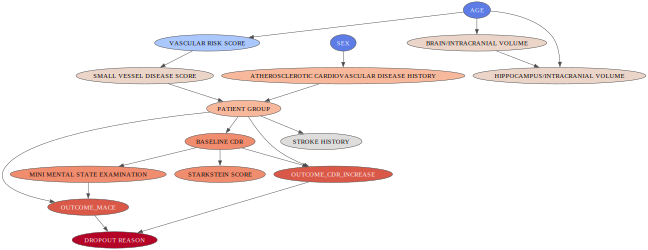

NoneInference given that CDR_INCREASE = No


In [23]:
gnb.sideBySide(
    *[
        gnb.showBN(bn_joint, size="9", nodeColor=node_colors, cmapNode=plt.get_cmap("coolwarm"))
    ],
    captions=[f"Inference given that CDR_INCREASE = {label}" for label in cdr_labels],
    ncols=1
)

### 6.2 Joint inference for CDR and MACE

Inspect posterior behaviour when conditioning on both outcome nodes simultaneously.

Focus on the parents of each outcome to summarise the conditional probability tables.

In [24]:
# Create inference engine
ie = gum.LazyPropagation(bn_joint)
ie.makeInference()

# Compute MI and apply it to arcs using variable indices (not names)
arc_width = {}

for u, v in bn_joint.arcs():  # u and v are variable IDs
    try:
        it = gum.InformationTheory(ie, v, [u])  # use IDs directly
        mi = it.mutualInformationXY()
    except:
        mi = 0.1

    arc_width[(u, v)] = mi  # ✅ use indices, not names

max_mi = max(arc_width.values())
arc_width = {k: (np.sqrt(v) / np.sqrt(max_mi) * 3.0 + 0.5) for k, v in arc_width.items()}


In [25]:
var_name_to_id = {bn_joint.variable(i).name(): i for i in range(bn_joint.size())}

bootstrap_freq_id = {}

for (parent_name, child_name), freq in edge_freqs.items():
    try:
        parent_id = var_name_to_id[parent_name]
        child_id = var_name_to_id[child_name]
        bootstrap_freq_id[(parent_id, child_id)] = freq
    except KeyError:
        continue  # skip if variable not found in network

In [26]:
arc_label = {
    arc: f"f={int(bootstrap_freq_id.get(arc, 0.0) * 100)}%"
    for arc in bn_joint.arcs()
}

In [27]:
arc_label

{(0, 7): 'f=96%',
 (14, 4): 'f=100%',
 (4, 3): 'f=71%',
 (8, 7): 'f=63%',
 (0, 13): 'f=100%',
 (2, 10): 'f=64%',
 (6, 14): 'f=99%',
 (14, 10): 'f=92%',
 (4, 2): 'f=96%',
 (11, 12): 'f=100%',
 (0, 8): 'f=95%',
 (13, 6): 'f=86%',
 (9, 14): 'f=33%',
 (4, 11): 'f=75%',
 (10, 12): 'f=100%',
 (1, 9): 'f=97%',
 (14, 5): 'f=100%',
 (14, 11): 'f=100%'}

In [28]:
arc_color_values = {
    arc: bootstrap_freq_id.get(arc, 0.0)
    for arc in bn_joint.arcs()
}


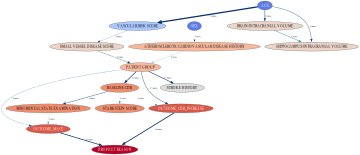

In [29]:
# Plot with MI-based edge widths
gnb.showBN(
    bn_joint,
    arcWidth=arc_width,
    nodeColor=node_colors,
    arcColor=arc_color_values,
    arcLabel=arc_label,
    cmapNode=plt.get_cmap("coolwarm"),
    cmapArc=plt.get_cmap("Blues")
)

In [56]:
df_imp.head()

,AGE,SEX,PTAU181,NFL,GFAP,AB40,AB42,MINI MENTAL STATE EXAMINATION,STARKSTEIN SCORE,BASELINE CDR,...,BIOMARKER SCORE 2,HIPPOCAMPUS/INTRACRANIAL VOLUME,BRAIN/INTRACRANIAL VOLUME,CEREBRAL BLOOD FLOW,ATHEROSCLEROTIC CARDIOVASCULAR DISEASE HISTORY,OUTCOME_MACE,OUTCOME_CDR_INCREASE,DROPOUT REASON,VASCULAR RISK SCORE,PATIENT GROUP
0,58.929500,1.0,2.167700,11.135018,153.128545,109.304989,6.956860,29.0,17.0,0.5,...,0.112833,0.148056,82.956121,55.5574,No,Unobserved,Unobserved,Other,8.4,1.0
1,57.464750,0.0,0.951074,12.241553,105.655261,113.991180,5.197182,28.0,7.0,0.5,...,-0.516713,0.142228,85.009808,50.0680,No,No,No,No Dropout,10.0,1.0
2,62.464066,0.0,0.944169,17.346210,69.483929,100.077280,6.615191,29.0,15.0,0.5,...,0.197913,0.116044,75.070512,56.1078,Yes,Unobserved,Unobserved,Refusal,9.5,0.0
3,81.475702,1.0,3.123887,38.966101,93.721259,144.314806,11.023838,24.0,9.0,0,...,0.859968,0.130733,74.981904,55.5076,Yes,Unobserved,Unobserved,Refusal,22.4,0.0
4,85.483915,1.0,3.308229,47.927891,180.980266,129.650860,8.041534,27.0,14.0,0.5,...,0.442229,0.135609,75.197876,71.3985,No,Unobserved,Unobserved,Deceased,24.3,0.0


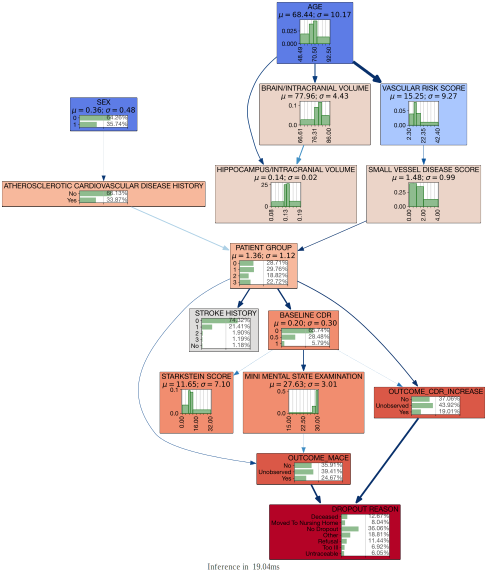

In [30]:
# Plot with MI-based edge widths
gnb.showInference(
    bn_joint,
    arcWidth=arc_width,
    nodeColor=node_colors,
    arcColor=arc_color_values,
    cmapNode=plt.get_cmap("coolwarm"),
    cmapArc=plt.get_cmap("Blues")
)

Here, the whole network is considered

In [31]:
gnb.sideBySide(
  "<H3>OUTCOME CDR INCREASE</H3>",
  "<H3>OUTCOME MACE</H3>",
  bn_joint.cpt("OUTCOME_CDR_INCREASE"),
  bn_joint.cpt("OUTCOME_MACE"),
  ncols=2,
)

### 6.3 Uncorrected mutual information — CDR_INCREASE

In [32]:
# Initialize inference engine
ie = gum.LazyPropagation(bn_joint)

# Get all variables in the network except the outcome
all_variables = bn_joint.names()
variables_to_test = [var for var in all_variables if var != 'OUTCOME_CDR_INCREASE']

# Store results
mi_results = {}

for var in variables_to_test:
    try:
        it = gum.InformationTheory(ie, 'OUTCOME_CDR_INCREASE', [var])
        mi = it.mutualInformationXY()  # Without correction
        mi_results[var] = mi
        print(f'Mutual Information ({var} -> OUTCOME_CDR_INCREASE): {mi:.6f}')
    except Exception as e:
        print(f'Error processing variable {var}: {e}')

# Optional: sort results
sorted_mi = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)

print("\nVariable Importance Ranking for OUTCOME_CDR_INCREASE (Raw Mutual Information)")
for var, score in sorted_mi:
    print(f'{var}: {score:.6f}')

Mutual Information (SEX -> OUTCOME_CDR_INCREASE): 0.000395
Mutual Information (HIPPOCAMPUS/INTRACRANIAL VOLUME -> OUTCOME_CDR_INCREASE): 0.000039
Mutual Information (VASCULAR RISK SCORE -> OUTCOME_CDR_INCREASE): 0.000468
Mutual Information (OUTCOME_MACE -> OUTCOME_CDR_INCREASE): 0.009627
Mutual Information (STROKE HISTORY -> OUTCOME_CDR_INCREASE): 0.007033
Mutual Information (PATIENT GROUP -> OUTCOME_CDR_INCREASE): 0.125145
Mutual Information (STARKSTEIN SCORE -> OUTCOME_CDR_INCREASE): 0.001729
Mutual Information (SMALL VESSEL DISEASE SCORE -> OUTCOME_CDR_INCREASE): 0.007657
Mutual Information (BRAIN/INTRACRANIAL VOLUME -> OUTCOME_CDR_INCREASE): 0.000059
Error processing variable DROPOUT REASON: [pyAgrum] Undefined element: The variable DROPOUT REASON(12) does not belong to this optimized inference.
Mutual Information (BASELINE CDR -> OUTCOME_CDR_INCREASE): 0.038288
Mutual Information (MINI MENTAL STATE EXAMINATION -> OUTCOME_CDR_INCREASE): 0.006067
Mutual Information (ATHEROSCLEROTIC 

### 6.4 Corrected mutual information — CDR_INCREASE

In [33]:
# Initialize inference engine
ie = gum.LazyPropagation(bn_joint)

# Get the parents of OUTCOME_CDR_INCREASE
parents = bn_joint.parents(bn_joint.idFromName('OUTCOME_CDR_INCREASE'))
parent_names = [bn_joint.variable(p).name() for p in parents]

# Get all variables in the network except OUTCOME_CDR_INCREASE and its parents
all_variables = bn_joint.names()
variables_to_test = [var for var in all_variables if var != 'OUTCOME_CDR_INCREASE' and var not in parent_names]

# Initialize dictionary to store results
cmi_results = {}

# Loop through each variable and compute conditional mutual information
for var in variables_to_test:
    try:
        it = gum.InformationTheory(ie, 'OUTCOME_CDR_INCREASE', [var], parent_names)
        cmi = it.mutualInformationXYgivenZ()
        cmi_results[var] = cmi
        print(f'Corrected MI ({var} -> OUTCOME_CDR_INCREASE | {parent_names}): {cmi:.6f}')
    except Exception as e:
        print(f'Error processing variable {var}: {e}')

# Optional: sort and display ranking
sorted_cmi = sorted(cmi_results.items(), key=lambda x: x[1], reverse=True)

print("\nVariable Importance Ranking for OUTCOME_CDR_INCREASE (Corrected Mutual Information)")
for var, score in sorted_cmi:
    print(f'{var}: {score:.6f}')

Corrected MI (SEX -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (HIPPOCAMPUS/INTRACRANIAL VOLUME -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (VASCULAR RISK SCORE -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (OUTCOME_MACE -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (STROKE HISTORY -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (STARKSTEIN SCORE -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): -0.000000
Corrected MI (SMALL VESSEL DISEASE SCORE -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (BRAIN/INTRACRANIAL VOLUME -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): -0.000000
Corrected MI (DROPOUT REASON -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.286946
Corrected MI (MINI MENTAL STATE EXAMINATION -> OUTCOME_CDR_INCRE

### 6.5 Uncorrected mutual information — EVENT_MACE

In [34]:
# Initialize inference engine
ie = gum.LazyPropagation(bn_joint)

# Get all variables in the network except the outcome
all_variables = bn_joint.names()
variables_to_test = [var for var in all_variables if var != 'OUTCOME_MACE']

# Store results
mi_results = {}

for var in variables_to_test:
    try:
        it = gum.InformationTheory(ie, 'OUTCOME_MACE', [var])
        mi = it.mutualInformationXY()  # Without correction
        mi_results[var] = mi
        print(f'Mutual Information ({var} -> OUTCOME_MACE): {mi:.6f}')
    except Exception as e:
        print(f'Error processing variable {var}: {e}')

# Optional: sort results
sorted_mi = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)

print("\nVariable Importance Ranking for OUTCOME_MACE (Raw Mutual Information)")
for var, score in sorted_mi:
    print(f'{var}: {score:.6f}')

Mutual Information (SEX -> OUTCOME_MACE): 0.000289
Mutual Information (HIPPOCAMPUS/INTRACRANIAL VOLUME -> OUTCOME_MACE): 0.000012
Mutual Information (VASCULAR RISK SCORE -> OUTCOME_MACE): 0.000142
Mutual Information (STROKE HISTORY -> OUTCOME_MACE): 0.002311
Mutual Information (PATIENT GROUP -> OUTCOME_MACE): 0.067852
Mutual Information (STARKSTEIN SCORE -> OUTCOME_MACE): 0.000761
Mutual Information (OUTCOME_CDR_INCREASE -> OUTCOME_MACE): 0.009627
Mutual Information (SMALL VESSEL DISEASE SCORE -> OUTCOME_MACE): 0.002663
Mutual Information (BRAIN/INTRACRANIAL VOLUME -> OUTCOME_MACE): 0.000018
Error processing variable DROPOUT REASON: [pyAgrum] Undefined element: The variable DROPOUT REASON(12) does not belong to this optimized inference.
Mutual Information (BASELINE CDR -> OUTCOME_MACE): 0.013873
Mutual Information (MINI MENTAL STATE EXAMINATION -> OUTCOME_MACE): 0.045900
Mutual Information (ATHEROSCLEROTIC CARDIOVASCULAR DISEASE HISTORY -> OUTCOME_MACE): 0.006245
Mutual Information (AG

### 6.6 Corrected mutual information — EVENT_MACE

In [35]:
# Initialize inference engine
ie = gum.LazyPropagation(bn_joint)

# Get the parents of EVENT_MACE
parents = bn_joint.parents(bn_joint.idFromName('OUTCOME_MACE'))
parent_names = [bn_joint.variable(p).name() for p in parents]

# Get all variables in the network except OUTCOME_MACE and its parents
all_variables = bn_joint.names()
variables_to_test = [var for var in all_variables if var != 'OUTCOME_MACE' and var not in parent_names]

# Initialize dictionary to store results
cmi_results = {}

# Loop through each variable and compute conditional mutual information
for var in variables_to_test:
    try:
        it = gum.InformationTheory(ie, 'OUTCOME_MACE', [var], parent_names)
        cmi = it.mutualInformationXYgivenZ()
        cmi_results[var] = cmi
        print(f'Corrected MI ({var} -> OUTCOME_MACE | {parent_names}): {cmi:.6f}')
    except Exception as e:
        print(f'Error processing variable {var}: {e}')

# Optional: sort and display ranking
sorted_cmi = sorted(cmi_results.items(), key=lambda x: x[1], reverse=True)

print("\nVariable Importance Ranking for OUTCOME_MACE (Corrected Mutual Information)")
for var, score in sorted_cmi:
    print(f'{var}: {score:.6f}')

Corrected MI (SEX -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PATIENT GROUP']): -0.000000
Corrected MI (HIPPOCAMPUS/INTRACRANIAL VOLUME -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PATIENT GROUP']): 0.000000
Corrected MI (VASCULAR RISK SCORE -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PATIENT GROUP']): 0.000000
Corrected MI (STROKE HISTORY -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PATIENT GROUP']): 0.000000
Corrected MI (STARKSTEIN SCORE -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PATIENT GROUP']): 0.000000
Corrected MI (OUTCOME_CDR_INCREASE -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PATIENT GROUP']): 0.000000
Corrected MI (SMALL VESSEL DISEASE SCORE -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PATIENT GROUP']): -0.000000
Corrected MI (BRAIN/INTRACRANIAL VOLUME -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PATIENT GROUP']): 0.000000
Corrected MI (DROPOUT REASON -> OUTCOME_MACE | ['MINI MENTAL STATE EXAMINATION', 'PA

## 7. Biomarker Layer Ablation

Contrast networks learned with and without the specialised biomarker layer.

In [36]:
import random
from itertools import product

def build_bn_biomarkers(df, outcomes, layer_map, type_processor, score='K2', use_tabu=True, random_seed=42):
    
    random.seed(random_seed)
    np.random.seed(random_seed)

    # Step 1: Drop excluded outcome variables and excluded biomarkers
    outcomes_all_layers = [v for k, v in layer_map.items() if "Outcomes" in k or "Dropout" in k]
    outcomes_flat = [var for sublist in outcomes_all_layers for var in sublist]
    drop_outcomes = list(set(outcomes_flat) - set(outcomes))

    df_reduced = df.drop(columns=drop_outcomes, errors='ignore')
    variables_to_keep = df_reduced.columns.tolist()

    # Step 2: Build template from reduced dataframe
    template_reduced = type_processor.discretizedTemplate(df_reduced)

    # Step 3: Instantiate the learner
    learner = gum.BNLearner(df_reduced, template_reduced)

    if score.upper() == 'K2':
        learner.useScoreK2()
    elif score.upper() == 'BIC':
        learner.useScoreBIC()
        learner.useSmoothingPrior()
    elif score.upper() == "BDEU":
        learner.useScoreBDeu(ess=1)
    else:
        raise ValueError("Unsupported score method: choose 'K2' or 'BIC'")

    if use_tabu:
        learner.useLocalSearchWithTabuList()
    else:
        learner.useGreedyHillClimbing()

  # Step 4: Build allowed arcs with special handling for dropout layer
    layer_keys = list(layer_map.keys())

    dropout_layer_keys = [k for k in layer_keys if "Dropout" in k]
    dropout_vars = []
    for key in dropout_layer_keys:
        dropout_vars += layer_map[key]

    allowed_arcs = []

    for i in range(len(layer_keys)):
        from_vars = layer_map[layer_keys[i]]
        for j in range(i, len(layer_keys)):
            to_vars = layer_map[layer_keys[j]]

            for parent, child in product(from_vars, to_vars):
                # Special rule: only allow arcs into dropout vars if from outcome
                if child in dropout_vars:
                    if parent in outcomes:
                        allowed_arcs.append((parent, child))
                    continue  # skip all others going into dropout

                if parent in variables_to_keep and child in variables_to_keep:
                    allowed_arcs.append((parent, child))

    # Step 5: Enforce allowed arcs, forbid the rest
    for parent in variables_to_keep:
        for child in variables_to_keep:
            if parent != child and (parent, child) not in allowed_arcs:
                learner.addForbiddenArc(parent, child)

    # Step 6: Disallow arcs between actual outcomes, but allow outcomes → dropout
    true_outcomes = [var for var in outcomes if "DROPOUT" not in var.upper()]
    for parent in true_outcomes:
        for child in true_outcomes:
            if parent != child:
                learner.addForbiddenArc(parent, child)

    learner.setMaxIndegree(5)
    # Step 7: Learn the network
    bn = learner.learnBN()
    return bn

In [37]:
bn_with_biomarkers = build_bn_biomarkers(df_imp, ["OUTCOME_CDR_INCREASE", "OUTCOME_MACE", "DROPOUT REASON"], layer_map=layer_map, type_processor=type_processor, score="K2")

### 7.1 Biomarker-outcome logistic regression

Quantify adjusted associations between each biomarker and the clinical outcomes using logistic regression models with age and sex as covariates.

In [ ]:
import statsmodels.formula.api as smf

biomarker_vars = [
    var for var in layer_map.get('L4 – Potential disease process markers', [])
    if var in df_imp.columns
]
outcome_labels = {
    'OUTCOME_MACE': 'MACE event',
    'OUTCOME_CDR_INCREASE': 'CDR increase'
}

logit_rows = []

for outcome, label in outcome_labels.items():
    observed = df_imp[df_imp[outcome].isin(['Yes', 'No'])].copy()
    if observed.empty:
        continue

    outcome_bin = f"{outcome}_bin"
    observed[outcome_bin] = (observed[outcome] == 'Yes').astype(int)

    for biomarker in biomarker_vars:
        biomarker_term = f'Q("{biomarker}")'
        model_specs = [
            {
                "label": "Unadjusted",
                "required_vars": [outcome_bin, biomarker],
                "formula_suffix": ""
            },
            {
                "label": "Adjusted (age + sex)",
                "required_vars": [outcome_bin, biomarker, 'AGE', 'SEX'],
                "formula_suffix": " + AGE + C(SEX)"
            },
        ]

        for spec in model_specs:
            missing_covars = [col for col in spec["required_vars"] if col not in observed.columns]
            if missing_covars:
                logit_rows.append({
                    'Outcome': label,
                    'Biomarker': biomarker,
                    'Model': spec["label"],
                    'Odds Ratio': np.nan,
                    'CI 2.5%': np.nan,
                    'CI 97.5%': np.nan,
                    'p-value': np.nan,
                    'N': 0,
                    'Notes': f"Missing covariates: {', '.join(missing_covars)}"
                })
                continue

            model_df = observed[spec["required_vars"]].dropna()
            sample_size = int(model_df.shape[0])

            if sample_size == 0:
                logit_rows.append({
                    'Outcome': label,
                    'Biomarker': biomarker,
                    'Model': spec["label"],
                    'Odds Ratio': np.nan,
                    'CI 2.5%': np.nan,
                    'CI 97.5%': np.nan,
                    'p-value': np.nan,
                    'N': sample_size,
                    'Notes': 'No complete cases after filtering'
                })
                continue

            if model_df[outcome_bin].nunique() < 2 or model_df[biomarker].nunique() < 2:
                logit_rows.append({
                    'Outcome': label,
                    'Biomarker': biomarker,
                    'Model': spec["label"],
                    'Odds Ratio': np.nan,
                    'CI 2.5%': np.nan,
                    'CI 97.5%': np.nan,
                    'p-value': np.nan,
                    'N': sample_size,
                    'Notes': 'Insufficient variation'
                })
                continue

            suffix = spec["formula_suffix"]
            formula = f"{outcome_bin} ~ {biomarker_term}{suffix}"

            try:
                fit = smf.logit(formula=formula, data=model_df).fit(disp=0)
            except Exception as exc:
                logit_rows.append({
                    'Outcome': label,
                    'Biomarker': biomarker,
                    'Model': spec["label"],
                    'Odds Ratio': np.nan,
                    'CI 2.5%': np.nan,
                    'CI 97.5%': np.nan,
                    'p-value': np.nan,
                    'N': sample_size,
                    'Notes': f'Fit failed: {exc}'
                })
                continue

            param_name = biomarker_term

            if param_name not in fit.params.index:
                logit_rows.append({
                    'Outcome': label,
                    'Biomarker': biomarker,
                    'Model': spec["label"],
                    'Odds Ratio': np.nan,
                    'CI 2.5%': np.nan,
                    'CI 97.5%': np.nan,
                    'p-value': np.nan,
                    'N': sample_size,
                    'Notes': 'Biomarker term dropped during fitting'
                })
                continue

            conf = fit.conf_int().loc[param_name]
            logit_rows.append({
                'Outcome': label,
                'Biomarker': biomarker,
                'Model': spec["label"],
                'Odds Ratio': np.exp(fit.params[param_name]),
                'CI 2.5%': np.exp(conf[0]),
                'CI 97.5%': np.exp(conf[1]),
                'p-value': fit.pvalues[param_name],
                'N': sample_size,
                'Notes': ''
            })

logit_results = pd.DataFrame(logit_rows)

if not logit_results.empty:
    display_order = ['Unadjusted', 'Adjusted (age + sex)']
    formatted = logit_results.copy()
    formatted['Model'] = pd.Categorical(formatted['Model'], categories=display_order, ordered=True)
    formatted['Odds Ratio (95% CI)'] = formatted.apply(
        lambda row: (
            f"{row['Odds Ratio']:.2f} ({row['CI 2.5%']:.2f}, {row['CI 97.5%']:.2f})"
            if pd.notnull(row['Odds Ratio']) else 'NA'
        ),
        axis=1
    )
    formatted['p-value'] = formatted['p-value'].map(
        lambda x: f"{x:.3g}" if pd.notnull(x) else 'NA'
    )
    formatted = formatted.sort_values(['Outcome', 'Biomarker', 'Model']).reset_index(drop=True)

    wide = (
        formatted
        .pivot_table(
            index=['Outcome', 'Biomarker', 'N'],
            columns='Model',
            values=['Odds Ratio (95% CI)', 'p-value'],
            aggfunc='first'
        )
        .sort_index()
    )

    wide.columns = [f"{metric} ({model})" for metric, model in wide.columns]
    wide = wide.reset_index()
    display(wide[['Outcome', 'Biomarker', 'N'] + [col for col in wide.columns if col not in {'Outcome', 'Biomarker', 'N'}]])
else:
    display(pd.DataFrame({'Message': ['No logistic regression models were fitted.']}))


#### Biomarker distribution checks

Visualise biomarker levels by CDR outcome status to verify the magnitude of group differences suggested by the logistic regression.

In [ ]:

import seaborn as sns

display_vars = ['BIOMARKER SCORE 1', 'BIOMARKER SCORE 2']
observed_cdr = df_imp[df_imp['OUTCOME_CDR_INCREASE'].isin(['Yes', 'No'])].copy()
if not observed_cdr.empty:
    long_df = observed_cdr.melt(
        id_vars=['OUTCOME_CDR_INCREASE'],
        value_vars=[var for var in display_vars if var in observed_cdr.columns],
        var_name='Biomarker',
        value_name='Value'
    ).dropna()

    if not long_df.empty:
        outcome_order = ['No', 'Yes']

        sns.set_style('whitegrid')
        n_biomarkers = long_df['Biomarker'].nunique()
        fig, axes = plt.subplots(1, n_biomarkers, figsize=(6 * n_biomarkers, 5), sharey=True)
        if n_biomarkers == 1:
            axes = [axes]

        for ax, (biomarker, subset) in zip(axes, long_df.groupby('Biomarker')):
            sns.boxplot(
                data=subset,
                x='OUTCOME_CDR_INCREASE',
                y='Value',
                order=outcome_order,
                palette=['#4C72B0', '#DD8452'],
                ax=ax
            )
            sns.stripplot(
                data=subset,
                x='OUTCOME_CDR_INCREASE',
                y='Value',
                order=outcome_order,
                color='black',
                alpha=0.4,
                size=4,
                jitter=True,
                ax=ax
            )
            ax.set_title(biomarker)
            ax.set_xlabel('CDR increase')
            ax.set_ylabel(biomarker if ax is axes[0] else '')

        fig.suptitle('Biomarker distributions by CDR increase status', y=1.03)
        plt.tight_layout()
    else:
        print('No biomarker measurements available after filtering.')
else:
    print('No observed CDR increase outcomes to plot.')


In [38]:
# Create inference engine
ie = gum.LazyPropagation(bn_with_biomarkers)
ie.makeInference()

# Compute MI and apply it to arcs using variable indices (not names)
arc_width = {}

for u, v in bn_with_biomarkers.arcs():  # u and v are variable IDs
    try:
        it = gum.InformationTheory(ie, v, [u])  # use IDs directly
        mi = it.mutualInformationXY()
    except:
        mi = 0.1

    arc_width[(u, v)] = mi  # ✅ use indices, not names

max_mi = max(arc_width.values())
arc_width = {k: (np.sqrt(v) / np.sqrt(max_mi) * 3.0 + 0.5) for k, v in arc_width.items()}

In [39]:
var_name_to_id = {bn_with_biomarkers.variable(i).name(): i for i in range(bn_with_biomarkers.size())}

bootstrap_freq_id = {}

for (parent_name, child_name), freq in edge_freqs.items():
    try:
        parent_id = var_name_to_id[parent_name]
        child_id = var_name_to_id[child_name]
        bootstrap_freq_id[(parent_id, child_id)] = freq
    except KeyError:
        continue  # skip if variable not found in network

In [40]:
# Update layer_order for color mapping and arc logic
layer_order = [
    'L0 – Unmodifiable demographics',
    'L1 – Modifiable demograhpics / Lifestyle factors',
    'L2 – Cardiovascular risk factors',
    'L3 – Specialized biomarkers',  # <-- NEW LAYER
    'L4 – Potential disease process markers',
    'L5 - Imaging markers of neurovascular damage',
    'L6 – Current and previous cardiovascular diagnoses / Vascular interventions',
    'L7 - Functional status',
    'L8 – Outcomes',
    'L9 – Dropout'
]

In [41]:
# Set adjusted min and max color values
min_color_val = 0.111111
max_color_val = 0.99999
steps = len(layer_order) - 1

# Create adjusted color intensity map
layer_color_map = {
    name: min_color_val + i * (max_color_val - min_color_val) / steps
    for i, name in enumerate(layer_order)
}

# Build the nodeColor dictionary
node_colors = {}
for layer_name, variables in layer_map.items():
    color_val = layer_color_map.get(layer_name, 0.5)  # fallback if unknown
    for var in variables:
        if var in bn_with_biomarkers.names():
            node_colors[var] = color_val

In [42]:
from collections import defaultdict
def bootstrap_edge_frequencies(df, outcomes, layer_map, type_processor,
                                build_bn_func, n_bootstraps=100, score='K2', use_tabu=True, random_seed=42):
    edge_counts = defaultdict(int)

    for i in range(n_bootstraps):
        seed = random_seed + i
        random.seed(seed)
        np.random.seed(seed)

        # Bootstrap resample
        boot_df = df.sample(frac=1.0, replace=True, random_state=seed)

        try:
            bn = build_bn_func(boot_df, outcomes, layer_map, type_processor,
                               score=score, use_tabu=use_tabu, random_seed=seed)
        except Exception as e:
            print(f"Bootstrap {i} failed: {e}")
            continue

        # Count arcs
        for parent_id, child_id in bn.arcs():
            parent = bn.variable(parent_id).name()
            child = bn.variable(child_id).name()
            edge_counts[(parent, child)] += 1

    # Normalize to frequencies
    edge_frequencies = {edge: count / n_bootstraps for edge, count in edge_counts.items()}
    return edge_frequencies

In [43]:
# Met biomarkers
edge_freqs_with = bootstrap_edge_frequencies(
    df=df_imp,
    outcomes=["OUTCOME_CDR_INCREASE", "OUTCOME_MACE", "DROPOUT REASON"],
    layer_map=layer_map,
    type_processor=type_processor,
    build_bn_func=build_bn_biomarkers,
    n_bootstraps=10,
    score='K2',
    use_tabu=True

)

# Print top edges
for edge, freq in sorted(edge_freqs_with.items(), key=lambda x: -x[1]):
    print(f"{edge[0]} → {edge[1]}: {freq:.2f}")

PATIENT GROUP → STROKE HISTORY: 1.00
PATIENT GROUP → OUTCOME_CDR_INCREASE: 1.00
SEX → ATHEROSCLEROTIC CARDIOVASCULAR DISEASE HISTORY: 1.00
BASELINE CDR → MINI MENTAL STATE EXAMINATION: 1.00
OUTCOME_CDR_INCREASE → DROPOUT REASON: 1.00
PATIENT GROUP → BASELINE CDR: 1.00
SEX → CEREBRAL BLOOD FLOW: 1.00
AGE → GFAP: 1.00
AGE → NFL: 1.00
AGE → VASCULAR RISK SCORE: 1.00
GFAP → PTAU181: 0.90
SMALL VESSEL DISEASE SCORE → PATIENT GROUP: 0.90
OUTCOME_MACE → DROPOUT REASON: 0.90
VASCULAR RISK SCORE → CEREBRAL BLOOD FLOW: 0.80
AGE → HIPPOCAMPUS/INTRACRANIAL VOLUME: 0.80
HIPPOCAMPUS/INTRACRANIAL VOLUME → BRAIN/INTRACRANIAL VOLUME: 0.80
BASELINE CDR → OUTCOME_CDR_INCREASE: 0.80
SEX → NFL: 0.80
NFL → PTAU181: 0.80
CEREBRAL BLOOD FLOW → BRAIN/INTRACRANIAL VOLUME: 0.80
AGE → PTAU181: 0.80
AGE → AB40: 0.70
BIOMARKER SCORE 2 → PTAU181: 0.70
MINI MENTAL STATE EXAMINATION → OUTCOME_MACE: 0.70
AGE → BRAIN/INTRACRANIAL VOLUME: 0.70
VASCULAR RISK SCORE → NFL: 0.70
NFL → HIPPOCAMPUS/INTRACRANIAL VOLUME: 0.70
HI

In [44]:
# Create inference engine
ie = gum.LazyPropagation(bn_with_biomarkers)
ie.makeInference()

# Compute MI and apply it to arcs using variable indices (not names)
arc_width = {}

for u, v in bn_with_biomarkers.arcs():  # u and v are variable IDs
    try:
        it = gum.InformationTheory(ie, v, [u])  # use IDs directly
        mi = it.mutualInformationXY()
    except:
        mi = 0.1

    arc_width[(u, v)] = mi  # ✅ use indices, not names

max_mi = max(arc_width.values())
arc_width = {k: (np.sqrt(v) / np.sqrt(max_mi) * 3.0 + 0.5) for k, v in arc_width.items()}

In [45]:
# Use edge_freqs_with for the network with biomarkers!
var_name_to_id = {bn_with_biomarkers.variable(i).name(): i for i in range(bn_with_biomarkers.size())}

bootstrap_freq_id = {}

for (parent_name, child_name), freq in edge_freqs_with.items():  # <-- use edge_freqs_with here!
    try:
        parent_id = var_name_to_id[parent_name]
        child_id = var_name_to_id[child_name]
        bootstrap_freq_id[(parent_id, child_id)] = freq
    except KeyError:
        continue  # skip if variable not found in network

arc_color_values = {
    arc: bootstrap_freq_id.get(arc, 0.0)
    for arc in bn_with_biomarkers.arcs()
}

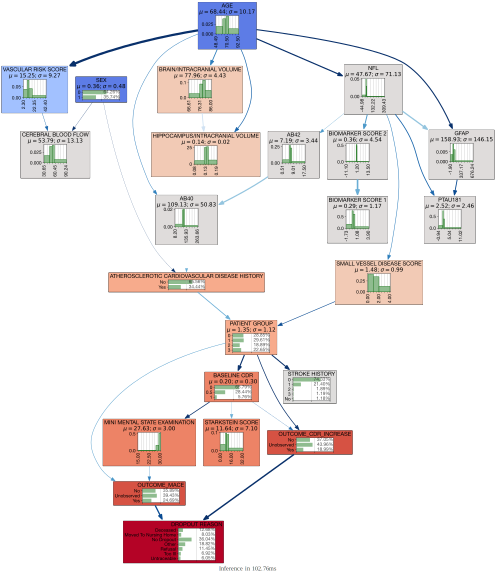

In [46]:
# Plot with MI-based edge widths
gnb.showInference(
    bn_with_biomarkers,
    arcWidth=arc_width,
    nodeColor=node_colors,
    arcColor=arc_color_values,
    cmapArc=plt.get_cmap("Blues"),
    cmapNode=plt.get_cmap("coolwarm")
    )

In [47]:
arc_label = {
    arc: f"f={int(bootstrap_freq_id.get(arc, 0.0) * 100)}%"
    for arc in bn_with_biomarkers.arcs()
}

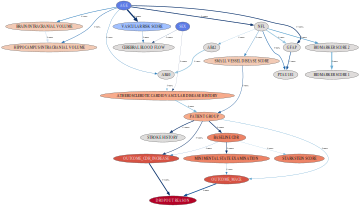

In [48]:
# Plot with MI-based edge widths
gnb.showBN(
    bn_with_biomarkers,
    arcWidth=arc_width,
    nodeColor=node_colors,
    arcColor=arc_color_values,
    arcLabel=arc_label,
    cmapNode=plt.get_cmap("coolwarm"),
    cmapArc=plt.get_cmap("Blues")
)

The specialised biomarkers appear upstream but are not directly connected to the outcomes; removing the layer leaves predictive behaviour largely unchanged.

In [49]:
gnb.showTensor(bn_with_biomarkers.cpt(bn_with_biomarkers.idFromName("OUTCOME_CDR_INCREASE")), digits=2)

In [50]:
gnb.showTensor(bn_with_biomarkers.cpt(bn_with_biomarkers.idFromName("OUTCOME_MACE")), digits=2)

In [51]:
# Initialize inference engine
ie = gum.LazyPropagation(bn_with_biomarkers)

# Get all variables in the network except the outcome
all_variables = bn_with_biomarkers.names()
variables_to_test = [var for var in all_variables if var != 'OUTCOME_MACE']

# Store results
mi_results = {}

for var in variables_to_test:
    try:
        it = gum.InformationTheory(ie, 'OUTCOME_MACE', [var])
        mi = it.mutualInformationXY()  # Without correction
        mi_results[var] = mi
        print(f'Mutual Information ({var} -> OUTCOME_MACE): {mi:.6f}')
    except Exception as e:
        print(f'Error processing variable {var}: {e}')

# Optional: sort results
sorted_mi = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)

print("\nVariable Importance Ranking for OUTCOME_MACE (Raw Mutual Information)")
for var, score in sorted_mi:
    print(f'{var}: {score:.6f}')

Mutual Information (BIOMARKER SCORE 2 -> OUTCOME_MACE): 0.000062
Mutual Information (PATIENT GROUP -> OUTCOME_MACE): 0.067807
Mutual Information (CEREBRAL BLOOD FLOW -> OUTCOME_MACE): 0.000034
Mutual Information (STROKE HISTORY -> OUTCOME_MACE): 0.002290
Mutual Information (BASELINE CDR -> OUTCOME_MACE): 0.013779
Mutual Information (HIPPOCAMPUS/INTRACRANIAL VOLUME -> OUTCOME_MACE): 0.000017
Mutual Information (AB42 -> OUTCOME_MACE): 0.000093
Mutual Information (SEX -> OUTCOME_MACE): 0.000261
Error processing variable DROPOUT REASON: [pyAgrum] Undefined element: The variable DROPOUT REASON(20) does not belong to this optimized inference.
Mutual Information (BRAIN/INTRACRANIAL VOLUME -> OUTCOME_MACE): 0.000026
Mutual Information (ATHEROSCLEROTIC CARDIOVASCULAR DISEASE HISTORY -> OUTCOME_MACE): 0.006321
Mutual Information (NFL -> OUTCOME_MACE): 0.000323
Mutual Information (BIOMARKER SCORE 1 -> OUTCOME_MACE): 0.000027
Mutual Information (VASCULAR RISK SCORE -> OUTCOME_MACE): 0.000087
Mutua

In [52]:
# Initialize inference engine
ie = gum.LazyPropagation(bn_with_biomarkers)

# Get all variables in the network except the outcome
all_variables = bn_with_biomarkers.names()
variables_to_test = [var for var in all_variables if var != 'OUTCOME_CDR_INCREASE']

# Store results
mi_results = {}

for var in variables_to_test:
    try:
        it = gum.InformationTheory(ie, 'OUTCOME_CDR_INCREASE', [var])
        mi = it.mutualInformationXY()  # Without correction
        mi_results[var] = mi
        print(f'Mutual Information ({var} -> OUTCOME_CDR_INCREASE): {mi:.6f}')
    except Exception as e:
        print(f'Error processing variable {var}: {e}')

# Optional: sort results
sorted_mi = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)

print("\nVariable Importance Ranking for OUTCOME_CDR_INCREASE (Raw Mutual Information)")
for var, score in sorted_mi:
    print(f'{var}: {score:.6f}')

Mutual Information (BIOMARKER SCORE 2 -> OUTCOME_CDR_INCREASE): 0.000156
Mutual Information (PATIENT GROUP -> OUTCOME_CDR_INCREASE): 0.124906
Mutual Information (CEREBRAL BLOOD FLOW -> OUTCOME_CDR_INCREASE): 0.000047
Mutual Information (STROKE HISTORY -> OUTCOME_CDR_INCREASE): 0.006975
Mutual Information (BASELINE CDR -> OUTCOME_CDR_INCREASE): 0.038091
Mutual Information (HIPPOCAMPUS/INTRACRANIAL VOLUME -> OUTCOME_CDR_INCREASE): 0.000035
Mutual Information (AB42 -> OUTCOME_CDR_INCREASE): 0.000129
Mutual Information (SEX -> OUTCOME_CDR_INCREASE): 0.000357
Error processing variable DROPOUT REASON: [pyAgrum] Undefined element: The variable DROPOUT REASON(20) does not belong to this optimized inference.
Mutual Information (BRAIN/INTRACRANIAL VOLUME -> OUTCOME_CDR_INCREASE): 0.000054
Mutual Information (ATHEROSCLEROTIC CARDIOVASCULAR DISEASE HISTORY -> OUTCOME_CDR_INCREASE): 0.008502
Mutual Information (NFL -> OUTCOME_CDR_INCREASE): 0.000813
Mutual Information (BIOMARKER SCORE 1 -> OUTCOME_

In [53]:
# Initialize inference engine
ie = gum.LazyPropagation(bn_with_biomarkers)

# Get the parents of OUTCOME_CDR_INCREASE
parents = bn_with_biomarkers.parents(bn_with_biomarkers.idFromName('OUTCOME_CDR_INCREASE'))
parent_names = [bn_with_biomarkers.variable(p).name() for p in parents]

# Get all variables in the network except OUTCOME_CDR_INCREASE and its parents
all_variables = bn_with_biomarkers.names()
variables_to_test = [var for var in all_variables if var != 'OUTCOME_CDR_INCREASE' and var not in parent_names]

# Initialize dictionary to store results
cmi_results = {}

# Loop through each variable and compute conditional mutual information
for var in variables_to_test:
    try:
        it = gum.InformationTheory(ie, 'OUTCOME_CDR_INCREASE', [var], parent_names)
        cmi = it.mutualInformationXYgivenZ()
        cmi_results[var] = cmi
        print(f'Corrected MI ({var} -> OUTCOME_CDR_INCREASE | {parent_names}): {cmi:.6f}')
    except Exception as e:
        print(f'Error processing variable {var}: {e}')

# Optional: sort and display ranking
sorted_cmi = sorted(cmi_results.items(), key=lambda x: x[1], reverse=True)

print("\nVariable Importance Ranking for OUTCOME_CDR_INCREASE (Corrected Mutual Information)")
for var, score in sorted_cmi:
    print(f'{var}: {score:.6f}')

Corrected MI (BIOMARKER SCORE 2 -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (CEREBRAL BLOOD FLOW -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (STROKE HISTORY -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (HIPPOCAMPUS/INTRACRANIAL VOLUME -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (AB42 -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (SEX -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.000000
Corrected MI (DROPOUT REASON -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): 0.287002
Corrected MI (BRAIN/INTRACRANIAL VOLUME -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): -0.000000
Corrected MI (ATHEROSCLEROTIC CARDIOVASCULAR DISEASE HISTORY -> OUTCOME_CDR_INCREASE | ['BASELINE CDR', 'PATIENT GROUP']): -0.000000
Corrected MI (NFL -> OUTCOME_CDR_INCREASE | ['BASEL

## 8. Scenario Exploration

Explore illustrative patient trajectories via direct inference and narrative summaries.

A patient with:
- a family history of TIA
- CVA in history
- No microbleeds
- COD
- No perivascular spaces

... has a 56% chance of MACE.

In [54]:
ie = gum.LazyPropagation(bn_joint)

# Healthy profile
healthy_evs = {
    'PATIENT GROUP': 'Reference',
    'SMALL VESSEL DISEASE SCORE': '0',
    'AGE': '58',
    'STARKSTEIN SCORE': '2',
    'MINI MENTAL STATE EXAMINATION': '29',
    'BASELINE CDR': '0',
    'SEX': 'Female'
}

# Calculate probabilities for healthy patient
ie.setEvidence(healthy_evs)
healthy_posterior = ie.posterior('OUTCOME_CDR_INCREASE')
print("Healthy Patient - OUTCOME_CDR_INCREASE probabilities:")
healthy_posterior

Exception: stod: no conversion

In [55]:
gnb.showInference(bn_joint, 
                  evs=healthy_evs, 
                  size="10!", 
                  nodeColor=node_colors, 
                  cmapNode=plt.get_cmap("coolwarm"))

Exception: stod: no conversion

In [57]:
ie = gum.LazyPropagation(bn_joint)

# Ill profile
ill_evs = {
    'PATIENT GROUP': 'Vascular cognitive impairment',
    'SMALL VESSEL DISEASE SCORE': '1',
    'AGE': '76',
    'BASELINE CDR': '0',
    'SEX': 'Male',
    'STARKSTEIN SCORE': '10',
    'MINI MENTAL STATE EXAMINATION': '28'
}


# Calculate probabilities for ill patient
ie.setEvidence(ill_evs)
ill_posterior = ie.posterior('OUTCOME_CDR_INCREASE')
print("Ill Patient - OUTCOME_CDR_INCREASE probabilities:")
ill_posterior

Ill Patient - OUTCOME_CDR_INCREASE probabilities:


(pyagrum.Tensor@0x15c845da0) 
  OUTCOME_CDR_INCREASE       |
No       |Unobserve|Yes      |
---------|---------|---------|
 0.2075  | 0.2453  | 0.5472  |

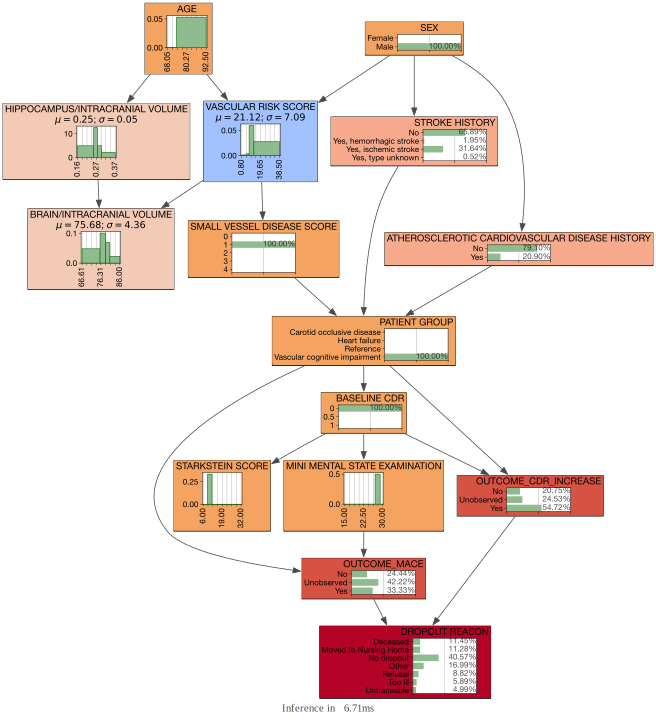

In [58]:
gnb.showInference(bn_joint, evs=ill_evs, size="10!", nodeColor=node_colors, cmapNode=plt.get_cmap("coolwarm"))

In [59]:
ie = gum.LazyPropagation(bn_joint)

# Ill profile
ill_evs = {
    'PATIENT GROUP': 'Vascular cognitive impairment',
    'SMALL VESSEL DISEASE SCORE': '2',
    'AGE': '76',
    'HIPPOCAMPUS/INTRACRANIAL VOLUME': '0.32',
    'BASELINE CDR': '0.5', 
    'STROKE HISTORY'
}

# Calculate probabilities for ill patient
ie.setEvidence(ill_evs)
ill_posterior = ie.posterior('OUTCOME_CDR_INCREASE')
print("Ill Patient - OUTCOME_CDR_INCREASE probabilities:")
ill_posterior

SyntaxError: ':' expected after dictionary key (2446147267.py, line 10)

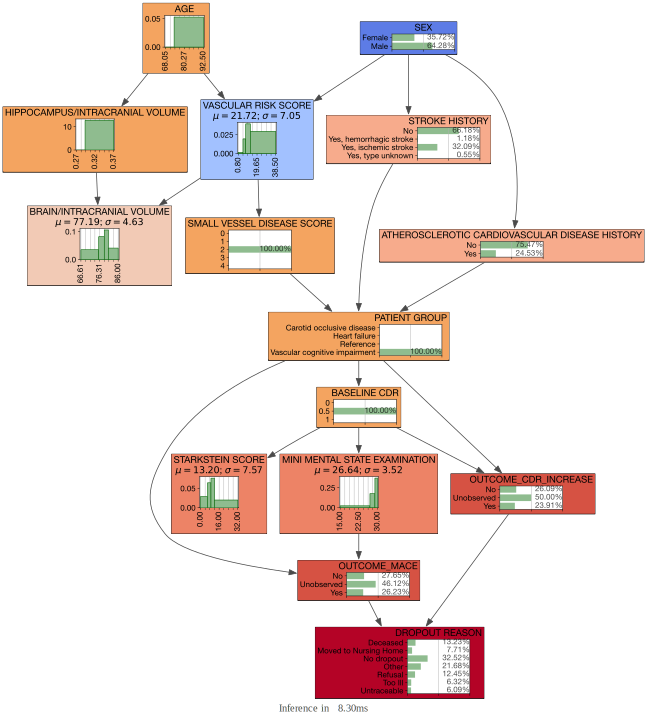

In [543]:
gnb.showInference(bn_joint, evs=ill_evs, size="10!", nodeColor=node_colors, cmapNode=plt.get_cmap("coolwarm"))

In [544]:
ie = gum.LazyPropagation(bn_joint)

# Ill profile
ill_evs = {
    'PATIENT GROUP': 'Vascular cognitive impairment',
    'SMALL VESSEL DISEASE SCORE': '2',
    'AGE': '76',
    'HIPPOCAMPUS/INTRACRANIAL VOLUME': '0.32',
    'BASELINE CDR': '1'
}

# Calculate probabilities for ill patient
ie.setEvidence(ill_evs)
ill_posterior = ie.posterior('OUTCOME_CDR_INCREASE')
print("Ill Patient - OUTCOME_CDR_INCREASE probabilities:")
ill_posterior

Ill Patient - OUTCOME_CDR_INCREASE probabilities:


(pyagrum.Tensor@0x1448642e0) 
  OUTCOME_CDR_INCREASE       |
No       |Unobserve|Yes      |
---------|---------|---------|
 0.0333  | 0.6000  | 0.3667  |

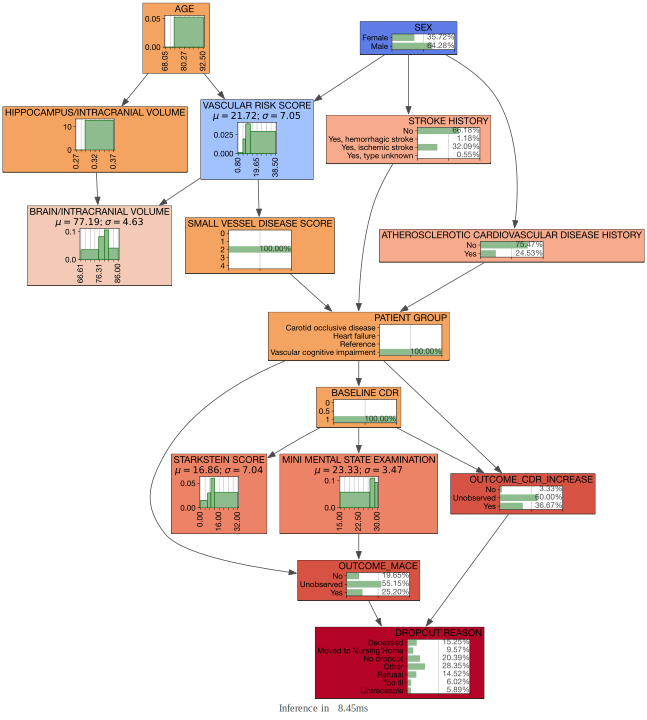

In [545]:
gnb.showInference(bn_joint, evs=ill_evs, size="10!", nodeColor=node_colors, cmapNode=plt.get_cmap("coolwarm"))

## 9. Persistence and Next Steps

Export the trained network and outline follow-up visual summaries.

In [212]:
# Persist the joint network for reuse outside the notebook
gum.saveBN(bn_joint, "bn_joint.bifxml")  # You can also use .net or .xdsl
